# Algoritmo Genético Versão Alpha $\alpha$

Essa versão inclui:
- Otimização da rota (V1)
- Otimização da quantidade de waypoints (V2)
- Risco Inflado: Inflação das áreas não-navegáveis (V3)


AINDA não está nessa versão:
- Alocação de risco (V3.5)

Ultimo update em 22/10/2019 - as 10:30 - Gustavo

# 1. Utils
Essa seção contém funções auxiliares para o algoritmo. Não é necessário mexer nessa parte
(Feche essa aba)

## utils.py

In [1]:
import itertools

# Support Functions
# _________________________________________________________________________________________________
def pairwise_circle(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ... (s<last>,s0)"
    a, b = itertools.tee(iterable)
    first_value = next(b, None)
    return itertools.zip_longest(a, b,fillvalue=first_value)

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)

# Ray Casting Algorithm
# _________________________________________________________________________________________________
epsilon = 0.00001  # Used on the Ray-Tracing Algorithm

def point_in_polygon(point, polygon):
    # Using ray_casting algorithm
    # https://rosettacode.org/wiki/Ray-casting_algorithm

    count = 0
    
    for vertex1, vertex2 in pairwise_circle(polygon):

        if vertex1.y < vertex2.y:
            A = vertex1
            B = vertex2
        else:
            A = vertex2
            B = vertex1

        if ray_intersects_segment(point, A, B):
            count += 1

    if count % 2 == 0: # Odd
        return False 
    else:
        return True # Inside the polygon
    

def ray_intersects_segment(P, A, B):
    # P : the point from which the ray starts
    # A : the end-point of the segment with the smallest y coordinate
    #     (A must be "below" B)
    # B : the end-point of the segment with the greatest y coordinate
    #     (B must be "above" A)

    # To avoid the "ray on vertex" problem, the point is moved upward of a small quantity epsilon.
    if P.y == A.y or P.y == B.y:
        P.y += epsilon

    # Point higher or lower than polygon
    if P.y < A.y or P.y > B.y:
        return False

    # Point to the right of the polygon
    elif P.x >= max(A.x, B.x):
        return False 

    else:

        if P.x < min(A.x, B.x):
            return True

        else:

            if A.x != B.x:
                m_red = (B.y - A.y)/(B.x - A.x)
            else:
                m_red = 99999999 # Infinite


            if A.x != P.x:
                m_blue = (P.y - A.y)/(P.x - A.x)
            else:
                m_blue = 99999999 # Infinite


            if m_blue >= m_red:
                return True
            else:
                return False



# Segment Intersection
# _________________________________________________________________________________________________
def segment_in_polygon(wp1, wp2, polygon):
    count = 0

    for vertex1, vertex2 in pairwise_circle(polygon):

        if vertex1.y < vertex2.y:
            A = vertex1
            B = vertex2
        else:
            A = vertex2
            B = vertex1

        if segment_intersects_segment(wp1, wp2, A, B):
            count += 1

    if count > 1:
        return True 
    else:
        return False 
    

def segment_intersects_segment(p1, q1, p2, q2):
    # Returns true if line segment 'p1q1' and 'p2q2' intersect. 
    # Based on the algorithm from https://www.geeksforgeeks.org/check-if-two-given-line-segments-intersect/

    
    # Two segments (p1,q1) and (p2,q2) intersect if and only if one of the following two conditions is verified:
    #
    # 1. General Case:
    # – (p1, q1, p2) and (p1, q1, q2) have different orientations and
    # – (p2, q2, p1) and (p2, q2, q1) have different orientations.
    #
    # 2. Special Case
    # – (p1, q1, p2), (p1, q1, q2), (p2, q2, p1), and (p2, q2, q1) are all collinear and
    # – the x-projections of (p1, q1) and (p2, q2) intersect
    # – the y-projections of (p1, q1) and (p2, q2) intersect
    
    
    # Find the four orientations needed for general and 
    # special cases 
    o1 = orientation(p1, q1, p2) 
    o2 = orientation(p1, q1, q2) 
    o3 = orientation(p2, q2, p1) 
    o4 = orientation(p2, q2, q1) 
    
    
    # 1. General case 
    if o1 != o2 and o3 != o4:
        return True  


    # 2. Special Cases 
    # p1, q1 and p2 are colinear and p2 lies on segment p1q1 
    if o1 == 0 and on_segment(p1, p2, q1): 
        return True 
  
    # p1, q1 and q2 are colinear and q2 lies on segment p1q1 
    if o2 == 0 and on_segment(p1, q2, q1):
        return True 
  
    # p2, q2 and p1 are colinear and p1 lies on segment p2q2 
    if o3 == 0 and on_segment(p2, p1, q2):
        return True 
  
    # p2, q2 and q1 are colinear and q1 lies on segment p2q2 
    if o4 == 0 and on_segment(p2, q1, q2):
        return True 
  
    
    # Doesn't fall in any of the above cases 
    return False 
    
    
def on_segment(p, q, r):
    # Given three colinear points p, q, r, the function checks if 
    # point q lies on line segment 'pr' 
    if (q.x <= max(p.x, r.x) and q.x >= min(p.x, r.x) 
    and q.y <= max(p.y, r.y) and q.y >= min(p.y, r.y)):
        return True
    else:
        return False
    
    
def orientation(p, q, r):
    # To find orientation of ordered triplet (p, q, r). 
    # The function returns following values 
    # 0 --> p, q and r are colinear 
    # 1 --> Clockwise 
    # 2 --> Counterclockwise 
    
    # See https://www.geeksforgeeks.org/orientation-3-ordered-points/ 
    # for details of below formula. 
      
    val =( (q.y - p.y) * (r.x - q.x) 
         - (q.x - p.x) * (r.y - q.y))
    
    if val == 0:
        return 0         # colinear

    return (1 if val > 0 else 2)  # clock or counterclock wise





## visualization.py

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path

import plotly.graph_objects as go

from sklearn import preprocessing


cor_area_nn    = '#25283d' # Yankees Blue
cor_area_p     = '#8f3985' # Plum
cor_area_b     = '#07beb8' # Tiffany Blue
cor_waypoints  = '#aa1155' # Jazzberry Jam
cor_ori_dest   = '#880044' # Pink Raspberry


def new_shape(vertices, color='navajowhite', lw=.25):

    assert len(vertices) >= 3, 'At least 3 vertices to form a shape'

    colors = {
        'n': cor_area_nn,
        'p': cor_area_p,
        'b': cor_area_b
    }
    
    color = colors[color] if color in colors else color
    
    codes = [Path.MOVETO]
    for _ in range(1, len(vertices)-1):
        codes.append(Path.LINETO)
    codes.append(Path.CLOSEPOLY)
    
    path = Path(vertices, codes)

    patch = patches.PathPatch(path, facecolor=color, lw=lw, alpha=0.6)

    return patch


def plot_map(areas, labels, origem, destino, waypoints, texts, wp_style='-x', **kwargs):

    fig, ax = plt.subplots(figsize=(8,8)) 
    
    # Plot areas
    if areas and labels:
        patches = [ new_shape(vertice, color=label) for vertice, label in zip(areas, labels) ]
        for patch in patches:
            ax.add_patch(patch)
        
    # Plot origin and destination
    if origem and destino:
        ax.plot([origem[0], destino[0]], [origem[1], destino[1]], 'o', color=cor_ori_dest)
    
    # Plot waypoints and route
    if waypoints:
        waypoints = list(map(list, zip(*waypoints)))
        ax.plot(waypoints[0], waypoints[1], wp_style, color=cor_waypoints, linewidth=2) #marker='x', linestyle='solid'
        if texts:
            for i, text in enumerate(texts):
                ax.annotate(text, (waypoints[0][i], waypoints[1][i]))
                
    # Plot segments
    if 'segments' in kwargs:
        for segment in kwargs['segments']:
            pass
    
    # Set size
    automin, automax = ax.get_xlim()
    plt.xlim(automin-0.5, automax+0.5)
    automin, automax = ax.get_ylim()
    plt.ylim(automin-0.5, automax+0.5)
    plt.gca().set_aspect('equal', adjustable='box')
    
    if 'title' in kwargs:
        plt.title(kwargs['title'])
    
    plt.show()
    #plt.savefig('out.png')

def plot_stats(ag_trace, normalize=True):
    dft = pd.DataFrame.from_dict(ag_trace)
    
    if normalize:
        x = dft.values #returns a numpy array
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x)
        dft = pd.DataFrame(x_scaled, columns=dft.columns)

    fig = go.Figure()

    for column in dft.columns:
        fig.add_trace(go.Scatter(x=dft.index, y=dft[column], name=column))
    fig.show()

In [3]:
def vis_mapa(mapa):
    areas = [ area for area in itertools.chain(mapa.areas_n, mapa.areas_n_inf) ]
    tipos = [ 'n' for _ in range(len(areas))]
    plot_map(
        areas,            # Mapa usado
        tipos,            # Tipo do mapa {'n','p','b'} <- Não afeta o genético, só muda a visualização
        mapa.origin,      # waypoint de origem
        mapa.destination, # waypoint de destino
        None,             # rota do melhor de todos
        None              # label para cada um dos waypoints da rota
    )

## data_definitions.py

In [4]:
import collections
import math

CartesianPoint = collections.namedtuple('CartesianPoint', 'x y')
GeoPoint = collections.namedtuple('GeoPoint', 'latitude, longitude, altitude')

class Mapa():
    def __init__(self, origin, destination, areas_n, inflation_rate=0.1, mode='scalar'):
        self.origin = origin           # CartesianPoint : Define o ponto de partida da rota
        self.destination = destination # CartesianPoint : Define o ponto de destino da rota
        self.areas_n = areas_n         # [area, ...]
                                       # area = [CartesianPoint(),...]      
        self.areas_n_inf = [ self._inflate_area(area, inflation_rate=inflation_rate, mode=mode) for area in areas_n ]
        
        
    def _inflate_area(self, area, inflation_rate, mode):
        if mode == 'percentage':
            # Infla uma área retangular em uma porcentagem do tamanho, alterando os valores em x% de cada vértice
            x = area[2].x - area[0].x
            y = area[1].y - area[3].y

            inc = (inflation_rate)
            dec = -(inflation_rate)

            new_area = [
                CartesianPoint(area[0].x + dec * x, area[0].y + dec * y), # left,  bottom
                CartesianPoint(area[1].x + dec * x, area[1].y + inc * y), # left,  top
                CartesianPoint(area[2].x + inc * x, area[2].y + inc * y), # right, top
                CartesianPoint(area[3].x + inc * x, area[3].y + dec * y)  # right, bottom
            ]
            new_area.append(new_area[0]) # Repetir primeiro ponto, para o ignore do shape na hora de plotar
        
        elif mode == 'scalar':
            # Infla uma área retangular em uma quantidade fixa
            inc = (inflation_rate)
            dec = -(inflation_rate)

            new_area = [
                CartesianPoint(area[0].x + dec, area[0].y + dec), # left,  bottom
                CartesianPoint(area[1].x + dec, area[1].y + inc), # left,  top
                CartesianPoint(area[2].x + inc, area[2].y + inc), # right, top
                CartesianPoint(area[3].x + inc, area[3].y + dec)  # right, bottom
            ]
            new_area.append(new_area[0]) # Repetir primeiro ponto, para o ignore do shape na hora de plotar
        
        
        return new_area



class Conversor():

    def list_geo_to_cart( l, geo_home):
        for i in l:
            yield Conversor.geo_to_cart(i, geo_home)

    def list_cart_to_geo( l, geo_home):
        for i in l:
            yield Conversor.cart_to_geo(i, geo_home)


    def geo_to_cart( geo_point, geo_home):
        
        def calc_y(lat, lat_):
            return (lat - lat_) * (10000000.0 / 90)
        def calc_x(longi, longi_, lat_):
            return (longi - longi_) * (6400000.0 * (math.cos(lat_ * math.pi / 180) * 2 * math.pi / 360))

        x = calc_x(geo_point.longitude, geo_home.longitude, geo_home.latitude)
        y = calc_y(geo_point.latitude, geo_home.latitude)

        #return CartesianPoint(x, y, geo_point.altitude)
        return CartesianPoint(x, y)


    def cart_to_geo( cartesian_point, geo_home):

        def calc_latitude_y(lat_, y):
            return ((y * 90) / 10000000.0) + lat_
        def calc_longitude_x(lat_, longi_, x):
            return ((x * 90) / (10008000 * math.cos(lat_ * math.pi / 180))) + longi_


        longitude_x = calc_longitude_x(geo_home.latitude, geo_home.longitude, cartesian_point.x)
        latitude_y = calc_latitude_y(geo_home.latitude, cartesian_point.y)

        #return GeoPoint(longitude_x, latitude_y, cartesian_point.z)
        return GeoPoint(longitude_x, latitude_y, 10)

# 2. Algoritmo Genético
Essa seção contém a implementação do algoritmo genético, contendo a definição da classe indivíduo (Subject) e da classe do genético (Genetic).
Aqui está a implementação, não é necessário mexer, a menos que queira mudar alguma coisa na lógica da solução. **Caso somente queira mexer nos parâmetros, pule para a próxima etapa**

### Utilitários

In [16]:
import collections
import random
import time
import copy

from math import cos, sin, sqrt, ceil

from itertools import tee
#from utils import pairwise, point_in_polygon, segment_in_polygon

Gene           = collections.namedtuple('Gene', 'a e')
GeneDecoded    = collections.namedtuple('GeneDecoded', 'x y v al')

## 2.1. Definição do Indivíduo

In [18]:
class Subject():
    
    # codificação - u
    # dna = [Gene, ...]
    #     Gene = [a, e]
    #         a = float: aceleração
    #         e = float: variação angular


    # decodificação - x
    # dna_decoded = [GeneDecoded, ...]
    #     GeneDecoded = (x, y, v, al)
    #         x  = : Posição do VANT no eixo x (aka px)
    #         y  = : Posição do VANT no eixo y (aka py)
    #         v  = : Velocidade do VANT na horizontal
    #         al = : ângulo (direção) do VANT na horizontal
    
    def __init__(
        self,
        px0=10.,
        py0=10.,
        v0=0,
        al0=0,
        v_min=11.1,
        v_max=30.5,
        e_min=-3,
        e_max=3,
        a_min=-2.0,
        a_max=2.0,
        T_min=1,
        T_max=7,
        delta_T=1,
        m=743.0,
        mutation_prob=0.7,
        spawn_mode='random',
        **kwargs
    ):
        # VANT
        # px0   int : Posição inicial no eixo x (m)
        # py0   int : Posição inicial no eixo y (m)
        # v0    int : Velocidade Inicial (m/s)
        # al0   int : Ângulo inicial (graus)
        self.gene_decoded_0 = GeneDecoded(px0, py0, v0, al0) # GeneDecoded : objeto contendo o gene decodificado de posição 0
        self.v_min = v_min # float : Velocidade máxima (m/s)
        self.v_max = v_max # float : Velocidade mínima (m/s)
        self.e_min = e_min # int   : Velocidade angular mínima (graus/s)
        self.e_max = e_max # int   : Velocidade angular máxima (graus/s)
        self.a_min = a_min # float : Aceleração mínima (m/s**2)
        self.a_max = a_max # float : Aceleração máxima (m/s**2)
        
        # TODO9:implementar os initialize
        
        # Modelo
        self.T_min   = T_min   # int : Valor mínimo para o horizonte de planejamento
        self.T_max   = T_max   # int : Valor máximo para o horizonte de planejamento
        self.T       = random.randint(T_min, T_max) # int : Horizonte de planejamento (quantidade de waypoints)
        self.delta_T = delta_T # int : Discretização do tempo (s) Tempo que leva de um waypoint até o outro
        self.m       = m       # float : Massa do VANT (!=0) (gramas)
    
        # Parametros do indivíduo
        self.mutation_prob = mutation_prob # float : Probabilidade de ocorrer uma mutação no dna (%)
        self.fitness       = None          # float : Fitness do indivíduo
        self.dna           = None          # list  : Conjunto de genes formando o DNA ([Gene, ...])
        self.dna_decoded   = None          # list  : DNA decodificado ([GeneDecoded, ...])
        self.spawn_mode    = spawn_mode    # str   : Tipo de incialização do DNA {'random'}
        
        self.spawn(mode=spawn_mode)
        
    
    def set_fitness(self, fitness, fitness_trace):
        self.fitness = fitness
        self.fitness_trace = fitness_trace
    
    
    # ---
    
    def spawn(self, mode):
        self.dna = [self._build_gene(mode) for _ in range(self.T) ]
        
    def _build_gene(self, mode='random'):
        # Inicialização aleatória gera valores com distribuição uniforme
        if mode == 'random':
            a = random.uniform(self.a_min, self.a_max)
            e = random.uniform(self.e_min, self.e_max)
            
        return Gene(a, e)
    
    # ---
    
    def decode(self):
        #self.dna_decoded = [self._decode_gene() for i in range(len(self.dna))]
        self.dna_decoded = self._decode_gene() # TODO: Organizar, voltar como era a linha de cima. Fazer função abaixo só computar o gene
        
    def _decode_gene(self):
        dna = self.dna
        
        # parametros
        delta_T = self.delta_T
        m = self.m
        
        dna_decoded = []
        dna_decoded.append(self.gene_decoded_0)
        
        for i in range(0, len(dna)):
            # dna
            a  = dna[i].a
            e  = dna[i].e
            
            # dna decodificado
            px = dna_decoded[i].x
            py = dna_decoded[i].y
            v  = dna_decoded[i].v
            al = dna_decoded[i].al
            
            F = self.__F(v)
        
            # Equações descritas em (Arantes 2016)
            _px = px + ( v * cos(al) * delta_T ) + ( a * cos(al) * ((delta_T**2)/2) ) 
            _py = py + ( v * sin(al) * delta_T ) + ( a * sin(al) * ((delta_T**2)/2) ) 
            _v  = v  + ( a * delta_T ) - ( (F/m) * delta_T )
            _al = al + ( e * delta_T )

            dna_decoded.append(GeneDecoded(_px, _py, _v, _al))

        return dna_decoded
    
    
    def __F(self, v):
        # Equação do Arrasto
        # Disponível em https://pt.wikipedia.org/wiki/Equa%C3%A7%C3%A3o_do_arrasto
        # Versão utilizada ((Arantes, 2016) equação 3.5)
        
        Cd  = 0.8     # float : Coeficiente de arrasto, específico para cada aeronave
                      #         (considerado Angled Cube) obtido de https://pt.wikipedia.org/wiki/Coeficiente_de_resist%C3%AAncia_aerodin%C3%A2mica
        rho = 1.225   # float : Massa específica do fuído (aka densidade) (k/m**3)
                      #         (a 15 graus Celsius) Valor de rho obtido de https://pt.m.wikipedia.org/wiki/Densidade_do_ar
        A = 1.0       # float : Área de referência # TODO: o que é isso?
        # v = v       # float : Velocidade do Vant no instante t (fornecido como parâmetro da função)
        
        F = 0.5 * Cd * rho * A * (v**2)
        
        return F
        
    
    # ---
    
    def crossover(self, parent2):
        dna = random.choice([self._OX, self._BLX_Alpha])(self.dna, parent2.dna)
        dna = self._complete(dna, self.dna, parent2.dna)
        child = self.generate(dna)
        return child
    
    
    def _complete(self, dna, dna1, dna2):
        # Adiciona os genes restantes da diferença de tamanho entre os dois DNAs
               
        if len(dna1) > len(dna2):
            bigger  = dna1
            smaller = dna2
        else:
            bigger  = dna2
            smaller = dna1
    
        for i in range(len(smaller)-1, len(bigger)-1):
            if random.random() < 0.5:
                dna.append(bigger[i])
                
        return dna
        
    
    def _OX(self, dna1, dna2):
        dna = []
        for gene1, gene2 in zip(dna1, dna2):
            dna.append(random.choice([gene1, gene2]))
        return dna
        
        
    def _BLX_Alpha(self, dna1, dna2):
        dna = []
        for gene1, gene2 in zip(dna1, dna2):
            a = self.__BLX_ALpha_select_gene(gene1.a, gene2.a)
            e = self.__BLX_ALpha_select_gene(gene1.e, gene2.e)
            a = min(a, self.a_max)
            a = max(a, self.a_min)
            e = min(e, self.e_max)
            e = max(e, self.e_min)
            
            gene = Gene(a, e)
            dna.append(gene)
            
        return dna
    
    
    def __BLX_ALpha_select_gene(self, x, y):
        # x - Gene : gene do pai 1
        # y - Gene : gene do pai 2
        alpha = random.uniform(0,1)
        d = abs(x-y)
        u = random.uniform(min(x,y)-alpha*d, max(x,y)+alpha*d)
        return u
    
    
    def generate(self, dna):
        # Cria um filho com os mesmos parametros do pai, mas com um dna fornecido
        child = copy.deepcopy(self)
        child.dna = dna
        child.decode()
        return child
    
        
    # ---
    
    def mutation(self, mutation_prob=None):
        mutation_prob = self.mutation_prob if not mutation_prob else mutation_prob # 0.7
        
        # Tem uma probabilidade mutation_prob de mutar o gene ou não
        if random.random() < mutation_prob:
            # Seleciona aleatoriamente uma das formas de mutação
            new_dna = random.choice([
                self._mutation_remove, 
                self._mutation_insert, 
                self._mutation_creep, 
                self._mutation_change
            ])(self.dna)
            
            if new_dna:
                self.dna = new_dna
                self.decode()
            
            return True
        return False
    
    def _mutation_change(self, dna):
        new_dna = []
        for gene in dna:
            if random.random() < 0.5:
                new_dna.append(self._build_gene('random'))
            else:
                new_dna.append(gene)
        
        return new_dna
    
    
    def _mutation_remove(self, dna):
        # Remove UM gene aleatório do DNA
        if len(dna) > self.T_min:
            i = random.randint(0, len(dna)-1)
            dna.pop(i)
            return dna
        return None
        
        
    def _mutation_insert(self, dna):
        # Insere UM gene aleatório no DNA em uma posição aleatória
        if len(dna) < self.T_max:
            i = random.randint(0, len(dna)-1)
            gene = self._build_gene()
            dna.insert(i, gene)
            return dna
        return None
    
    
    def _mutation_creep(self, dna):
        new_dna = []
        for gene in dna:
            a = self.__mute(gene.a, self.a_min, self.a_max)
            e = self.__mute(gene.e, self.e_min, self.e_max)

            # TODO2: otimizar
            new_gene = Gene(a, e)
            new_dna.append(new_gene)

        return new_dna
        
        
    def __mute(self, val, min_val, max_val):
        mutation_rate = random.uniform(0, max_val*0.5)
        s = random.choice([1, -1])
        val = val * (1 + (mutation_rate * s))

        # Checa se não estoura os limites
        val = max(val, min_val)
        val = min(val, max_val)

        return val
    
    
    # ---
    
    def get_route(self):
        return [ [gene.x, gene.y] for gene in self.dna_decoded ]
    


        

## 2.2. Definição do Genético

In [6]:
class Genetic():
    
    def __init__(
        self, 
        Specie, 
        mapa,
        taxa_cross=1.0,
        population_size=100,
        C_d=1000,
        C_obs=1000,
        C_con=10,
        C_cur=0,
        C_t=0,
        max_exec_time=5,
        min_precision=1.0,
        k_tournament=2,
        **kwargs
    ):
        # Modelo
        self.Specie = Specie # objeto : Definição da classe (não a instância)
        self.mapa   = mapa   # Mapa   : Mapa com as características da missão

        # Parâmetros
        self.taxa_cross      = taxa_cross      # float : Taxa de ocorrencia do crossover [0,1]
        self.population_size = population_size # int   : Quantidade máxima de indivíduos na população 
        self.C_d             = C_d             # int   : Custo associado ao fitness de destino
        self.C_obs           = C_obs           # int   : Custo associado ao fitness de obstáculos
        self.C_con           = C_con           # int   : Custo associado ao fitness de consumo de combustível
        self.C_cur           = C_cur           # int   : Custo associado ao fitness de curvatura da rota
        self.C_t             = C_t             # int   : Custo associado ao fitness do tamanho do DNA (T ou horizonte de planejamento)
        self.max_exec_time   = max_exec_time   # float : Tempo máximo de execução - Stop criteria (segundos)
        self.min_precision   = min_precision   # float : Precisão mínima de acerto ao destino (metros)
        self.k_tournament    = k_tournament    # int   : Quantidade de indivíduos disputando o torneio
        
        # Alguns dos valores do kwargs são passados para a instanciação dos indivíduos
        self.kwargs = kwargs
        
        # Inicialização
        self.population = None 
        self.fitnesses  = None
        self.best       = None
        self.ancestry   = []
        

        
    def run(self, max_exec_time=None, verbose=False, info=False, debug=False):
        self.max_exec_time = max_exec_time if max_exec_time else self.max_exec_time
        
        # Acompanhamento do tempo (critério de parada)
        self.start_time = time.time()
        
        # Genesis
        self.population = self._genesis(self.Specie, self.population_size)
        
        # Inicializar
        self._decode(self.population)
        
        # Avaliar
        self.fitnesses = [self._fitness(subject, self.mapa) for subject in self.population]
    
        # Escolher melhor de todos
        self.best = self.population[self.fitnesses.index(max(self.fitnesses))]
        
        
        self.trace = []
        
        while not self.stop_criteria():
            self.flag_newborn = self.population_size
            count_while = 0
            
            while not self.converge():
                self.flag_newborn = 0
                count_while += 1
                
                for i in range(ceil(self.taxa_cross * self.population_size)):
                    # Seleção por torneio
                    parent1, parent2 = self._tournament(self.population, k=self.k_tournament)
            
                    # Crossover
                    child = parent1.crossover(parent2)
                    
                    # Mutação
                    child.mutation()
                    
                    # Fitness
                    self._fitness(child, self.mapa)
                    
                    # Adicionar filho na população
                    self._insert(child, parent1, parent2)
                    
                    # Print
                    if verbose and self.flag_newbest:
                        print('  Novo melhor de todos! fit: {}'.format(self.best.fitness))
                    if debug:
                        print('\nparent1.dna', parent1.dna)
                        print('\nparent2.dna', parent2.dna)
                        print('\nchild.dna.mutation', child.dna)
                        
                        
                aux_T_dna = [len(subject.dna) for subject in self.population]
                self.trace.append({
                    'medium_fitness': sum(self.fitnesses)/self.population_size,
                    'best_fitness': self.best.fitness,
                    'newborns': self.flag_newborn,
                    'newbest': self.flag_newbest,
                    'T_medio': sum(aux_T_dna)/self.population_size,
                    'T_maior': max(aux_T_dna),
                    'T_menor': min(aux_T_dna),
                    'T_melhor': len(self.best.dna)
                })
                
                # Print
                if verbose:
                    print('Fim da geração. {} novos indivíduos'.format(self.flag_newborn))
                    print('Melhor de todos: {}'.format(self.best.fitness))
                    print('-'*20)
                        
                        
            # Reiniciar rotas
            self.population = []
            self.population = self._genesis(self.Specie, self.population_size-1)
            # Nunca matar o melhor de todos
            self.population.append(self.best)
            
            # Inicializar
            self._decode(self.population)
            
            # Avaliar
            self.fitnesses = [self._fitness(subject, self.mapa) for subject in self.population]
            
            # Print
            if verbose:
                print('Meteoro! Reiniciando rotas')
            if info:
                print('Meteoro! Melhor de todos:{} - count:{}'.format(self.best.fitness, count_while))
                
                
        return self.best
                      
    # ---
    
    def _insert(self, child, parent1, parent2):
        # Verifica se um indivíduo é digno de entrar na população e tomar o lugar de um de seus pais

        self.flag_newbest = False
        
        if child.fitness < parent1.fitness:
            self.__substitute(child, parent1)

        elif child.fitness < parent2.fitness:
            self.__substitute(child, parent2)

        if child.fitness < self.best.fitness:
            self.best = child
            self.ancestry.append(child)
            self.flag_newbest = True
    
    
    def __substitute(self, child, parent):
        i_parent = self.population.index(parent)

        self.population.remove(parent)
        self.population.append(child)

        self.fitnesses.pop(i_parent)
        self.fitnesses.append(child.fitness)
        self.flag_newborn += 1
    
    
    # ---
    
    def stop_criteria(self):
        # Para a execução depois de uma quantidade de segundos
        if (time.time() - self.start_time) >= self.max_exec_time:
            return True
        return False
    
    def converge(self):
        # Converge caso nenhum novo indivíduo seja adicinado
        if self.flag_newborn == 0:
            return True
        return False
                         
    # ---
    
    def _genesis(self, Specie, population_size):
        population = [Specie(**self.kwargs) for i in range(population_size)]
        return population 
    
    # ---
    
    def _decode(self, population):
        for subject in population:
            subject.decode()
        return True
    
    # ---
    
    def _fitness(self, subject, mapa):
        
        fit_d   = self.__fitness_destination(subject, mapa)
        fit_obs = self.__fitness_obstacles(subject, mapa)
        fit_con = self.__fitness_consumption(subject, mapa)
        fit_cur = self.__fitness_curves(subject, mapa)
        fit_t   = self.__fitness_t(subject, mapa)
        
        fitness_trace = [self.C_d   * fit_d,
                         self.C_obs * fit_obs,
                         self.C_con * fit_con,
                         self.C_cur * fit_cur,
                         self.C_t   * fit_t]
        
        fitness = sum(fitness_trace)
        
        subject.set_fitness(fitness, fitness_trace)
        
        return fitness
    
    def __fitness_destination(self, subject, mapa):
        # Prioriza rotas que acertem o destino
        
        A = subject.dna_decoded[-1] # Último waypoint da rota
        B = mapa.destination        # Waypoint de destino
        
        # Distância euclidiana entre o último ponto da rota e o ponto de destino
        d = sqrt( (B.x - A.x)**2 + (B.y - A.y)**2 )
        
        # Determina uma precisão mínima aceita
        if d < self.min_precision: # min_precision default = 1.0
            return 0
        return d

    
    def __fitness_obstacles(self, subject, mapa):
        # Prioriza rotas que não ultrapassem obstáculos
        count = 0
        
        for gene_decoded_t1, gene_decoded_t2  in pairwise(subject.dna_decoded):
            # Utiliza somente as áreas infladas para cálculo
            for area_n in mapa.areas_n_inf:
                wp1 = CartesianPoint(gene_decoded_t1.x, gene_decoded_t1.y)
                wp2 = CartesianPoint(gene_decoded_t2.x, gene_decoded_t2.y)
                
                # Calcula se algum waypoint está dentro de algum obstáculo
                if point_in_polygon(wp1, area_n):
                    count += 1
                    
                # Calcula se alguma conexão entre os waypoints intersecciona algum obstáculo
#                 if segment_in_polygon(wp1, wp2, area_n):
#                     count += 1
            
        return count
    
    
    def __fitness_consumption(self, subject, _):
        # Prioriza rotas com menor consumo de combustível (bateria)
        consumption = [gene.a**2 for gene in subject.dna]
        return sum(consumption)
    
        
    def __fitness_curves(self, subject, _):
        # Prioriza rotas que evitem fazer curvas desnecessárias
        curves = [abs(gene.e) for gene in subject.dna]
        return (1/subject.e_max) * sum(curves)
        
        
    def __fitness_t(self, subject, _):
        # Prioriza rotas com menor quantidade de waypoints
        return len(subject.dna)
    
        
    # ---
        
    def _tournament(self, population, k=2):
        parents = []
        for i in range(2):
            
            local_best = random.choice(population)
            for j in range(k-1):
                # Seleciona k individuos
                a = random.choice(population)
                if a.fitness > local_best.fitness:
                    local_best = a
                    
            parents.append(local_best)
            
        # Retorna o resultado de duas batalhas
        return parents[0], parents[1]
        
        

        
        
        

# 3. Execução
Essa seção contém a execução do AG. Aqui contém as definições dos mapas, e execução do planejador de rotas. Pode alterar os parâmetros a vontade para testar novos resultados

## 3.1. Mapas

### Mapa 1

In [7]:
wp_ori = CartesianPoint(10.0, 10.0)
wp_des = CartesianPoint(40.0, 10.0)

verts1 = [
    (20.0, 5.0), # left, bottom
    (20.0, 15.5), # left, top
    (30.0, 15.5), # right, top
    (30.0, 5.0), # right, bottom
    (20.0, 5.0), # ignored
]
verts1 = [CartesianPoint(v[0], v[1]) for v in verts1]


mapa_1 = Mapa(wp_ori, wp_des, [verts1], inflation_rate=1)

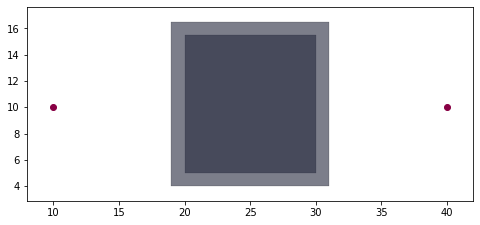

In [8]:
# Visualização desse mapa
vis_mapa(mapa_1)

### Mapa 2

In [9]:
wp_ori = CartesianPoint(10.0, 10.0)
wp_des = CartesianPoint(40.0, 10.0)

verts1 = [
    (15.0,  8.0), # left, bottom
    (15.0, 20.0), # left, top
    (20.0, 20.0), # right, top
    (20.0,  8.0), # right, bottom
    (20.0,  8.0), # ignored
]
verts1 = [CartesianPoint(v[0], v[1]) for v in verts1]

verts2 = [
    (30.0,  0.0), # left, bottom
    (30.0, 12.0), # left, top
    (35.0, 12.0), # right, top
    (35.0,  0.0), # right, bottom
    (35.0,  0.0), # ignored
]
verts2 = [CartesianPoint(v[0], v[1]) for v in verts2]

mapa_2 = Mapa(wp_ori, wp_des, [verts1, verts2], inflation_rate=1)

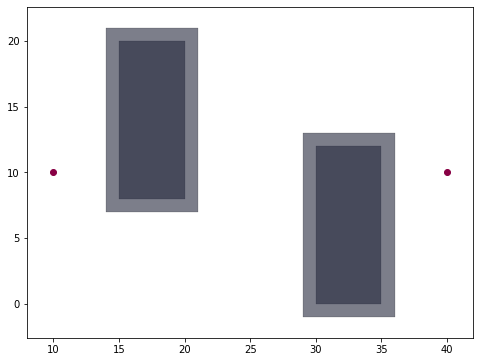

In [10]:
# Visualização desse mapa
vis_mapa(mapa_2)

### Mapa 3

In [11]:
wp_ori = CartesianPoint(10.0, 10.0)
wp_des = CartesianPoint(40.0, 10.0)

verts1 = [
    (15.0, 11.0), # left, bottom
    (15.0, 25.0), # left, top
    (35.0, 23.0), # right, top
    (35.0, 16.0), # right, bottom
    (35.0, 16.0), # ignored
]
verts1 = [CartesianPoint(v[0], v[1]) for v in verts1]

verts2 = [
    (15.0,  0.0), # left, bottom
    (15.0,  9.0), # left, top
    (35.0, 12.0), # right, top
    (35.0,  6.0), # right, bottom
    (35.0, 10.0), # ignored
]
verts2 = [CartesianPoint(v[0], v[1]) for v in verts2]

mapa_3 = Mapa(wp_ori, wp_des, [verts1, verts2], inflation_rate=0.5)

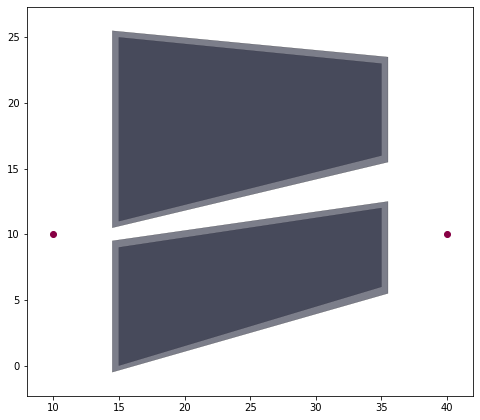

In [12]:
# Visualização desse mapa
vis_mapa(mapa_3)

## 3.2. Planejamento de Rota

Meteoro! Melhor de todos:10008.105160417434 - count:230
Meteoro! Melhor de todos:9213.56848105175 - count:250
Meteoro! Melhor de todos:9213.56848105175 - count:253
Meteoro! Melhor de todos:9213.56848105175 - count:185
Meteoro! Melhor de todos:9213.56848105175 - count:181
Meteoro! Melhor de todos:8416.026329179189 - count:271
Meteoro! Melhor de todos:8416.026329179189 - count:188
------------------------------
Gene(a=1.9031367439662688, e=0.008998946455997263)
Gene(a=1.5846967961881364, e=0.008914294347997252)
Gene(a=0.9932225926007612, e=0.15452709154146754)
Gene(a=0.04110344481657065, e=-0.002441487312946116)
Gene(a=0.18485219030133843, e=-0.026450485265792422)
Gene(a=0.20186698434800396, e=0.04797799830316188)
Gene(a=-0.10644869565223625, e=-0.8573806267207869)
Gene(a=0.18605929971149265, e=0.014656018121434355)
------------------------------
GeneDecoded(x=10.0, y=10.0, v=0, al=0)
GeneDecoded(x=10.951568371983134, y=10.0, v=1.9031367439662688, al=0.008998946455997263)
GeneDecoded(x=1

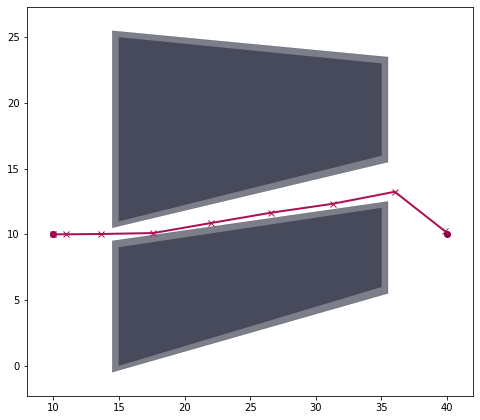

In [26]:
# ===============================================================
# --------------   UTILIZE ESSE ESPAÇO --------------------------

# Altere aqui o mapa que deseja utilizar
#mapa = mapa_1
#mapa = mapa_2
mapa = mapa_3


# Inicialização do Algoritmo
ag = Genetic(Subject, mapa, 
        # Parâmetros da classe Genetic:
        taxa_cross=1.0,
        population_size=80,
        C_d=1000,
        C_obs=10000,
        C_con=1000,
        C_cur=1000,
        C_t=100,
        max_exec_time=60, # segundos
        # Parâmetros da classe Subject:
        px0=mapa.origin.x,
        py0=mapa.origin.x,
        T_min=1,
        T_max=40,
        mutation_prob=0.7
)

# ===============================================================

# Execução do AG, retorna o melhor indivíduo
best = ag.run(info=True)

# Print do DNA do melhor
print('-'*30)
for dna in best.dna:
    print(dna)
    
# Print do DNA DECODIFICADO do melhor
print('-'*30)
for dna_decoded in best.dna_decoded:
    print(dna_decoded)
    
best = ag.best

# Visualização do Mapa usado, com a rota do melhor de todos
areas = [ area for area in itertools.chain(mapa.areas_n, mapa.areas_n_inf) ]
tipos = [ 'n' for _ in range(len(areas))]
plot_map(
    areas,            # Mapa usado
    tipos,            # Tipo do mapa {'n','p','b'} <- Não afeta o genético, só muda a visualização
    mapa.origin,      # waypoint de origem
    mapa.destination, # waypoint de destino
    best.get_route(), # rota do melhor de todos
    None              # label para cada um dos waypoints da rota
)


# Visualização de alguns gráficos de fitness e quantidade de Ts
#plot_stats(ag.trace, normalize=True)
#plot_stats(ag.trace, normalize=False)

#### Visualizar Detalhes do fitness

In [22]:
best.fitness_trace
# Destino Obstáculo Consumo Curva QtdWP

[21215.927957307875, 0, 2590.1018950735347, 82.98597272339596, 5000]

#### Recuperação de Erros
Caso o AG pare no meio da execução, é possível visualizar o melhor de todos gerado até o momento mesmo assim, basta rodar a célula abaixo

In [ ]:
best = ag.best

# Visualização do Mapa usado, com a rota do melhor de todos
areas = [ area for area in itertools.chain(mapa.areas_n, mapa.areas_n_inf) ]
tipos = [ 'n' for _ in range(len(areas))]
plot_map(
    areas,            # Mapa usado
    tipos,            # Tipo do mapa {'n','p','b'} <- Não afeta o genético, só muda a visualização
    mapa.origin,      # waypoint de origem
    mapa.destination, # waypoint de destino
    best.get_route(), # rota do melhor de todos
    None              # label para cada um dos waypoints da rota
)

# 4. Execução da Implementação em ROS

In [24]:
mapa_file = [
{
	"id": 0,
	"name": "Mapa C2",
	"geo_home": [-47.932949, -22.002467, 0],
	"areas_bonificadoras":[],
	"areas_penalizadoras":[],
	"areas_nao_navegaveis":[
		{
			"id": "NN1",
			"name": "Campo atras dos containers",
			"geo_points":[
				[-47.932749, -22.002332, 7], 
				[-47.932794, -22.002177, 13], 
				[-47.932664, -22.002147, 13], 
				[-47.932612, -22.002306, 7]
    			]
    		},
		{
			"id": "NN2",
			"name": "Bloco de aula",
			"geo_points":[
				[-47.932099, -22.002278, 20],
				[-47.932063, -22.002396, 20],
				[-47.932772, -22.002582, 20],
				[-47.932811, -22.002465, 20]
			]
		}
    ]
}
]

Meteoro! Melhor de todos:38070.22949383687 - count:94
Meteoro! Melhor de todos:38070.22949383687 - count:74
Meteoro! Melhor de todos:38070.22949383687 - count:75
Meteoro! Melhor de todos:38070.22949383687 - count:96
Meteoro! Melhor de todos:37061.836336785374 - count:120
Meteoro! Melhor de todos:30375.031141291132 - count:119
Meteoro! Melhor de todos:30375.031141291132 - count:89
Meteoro! Melhor de todos:30375.031141291132 - count:107
Meteoro! Melhor de todos:30375.031141291132 - count:116
Meteoro! Melhor de todos:30375.031141291132 - count:82
Meteoro! Melhor de todos:30375.031141291132 - count:61
Meteoro! Melhor de todos:30375.031141291132 - count:93
Meteoro! Melhor de todos:30375.031141291132 - count:72
Meteoro! Melhor de todos:30375.031141291132 - count:90
Meteoro! Melhor de todos:30375.031141291132 - count:65
Meteoro! Melhor de todos:30375.031141291132 - count:73
Meteoro! Melhor de todos:30375.031141291132 - count:99
Meteoro! Melhor de todos:30375.031141291132 - count:99
Meteoro! M

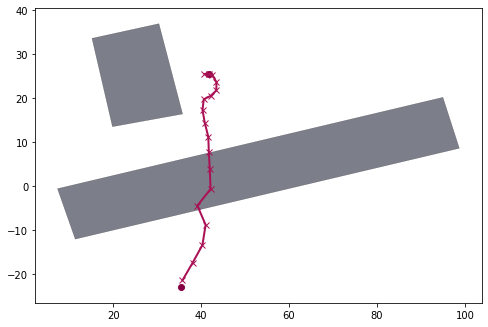

In [25]:
import argparse

from visualization import plot_map
from genetic_v2_3 import Subject, Genetic 
from data_definitions import Mapa, CartesianPoint, Conversor, GeoPoint

from file_manipulation import read_mapa, write_mavros, upload_mapa

## ENTRADA

# Parâmetros recebidos (arquivo .srv)
origin_lat       = -22.002237
origin_long      = -47.932546
origin_alt       = 13
destination_lat  = -22.002674 
destination_long = -47.932608
destination_alt  = 15

# P0
# destination_lat  = -22.002278 
# destination_long = -47.932099
# destination_alt  = 20

# P1
# destination_lat  = -22.002396 
# destination_long = -47.932063
# destination_alt  = 20


mapa_id          = 0

# Leitura do arquvio em DATA
#PATH = '/home/gustavosouza/Documents/Per/path-planning/data/mapa.json' #Ubuntu
PATH = r'../../data' #Windows
#geo_home, _, _, areas_n = read_mapa(PATH, mapa_id)
geo_home, _, _, areas_n = upload_mapa(mapa_file, mapa_id)

cart_origin      = Conversor.geo_to_cart(GeoPoint(origin_lat, origin_long, origin_alt), geo_home)
cart_destination = Conversor.geo_to_cart(GeoPoint(destination_lat, destination_long, destination_alt), geo_home)


mapa = Mapa(cart_origin, cart_destination, areas_n, inflation_rate=0.1)



## EXECUÇÃO DO AG

ag_teste = Genetic(Subject, mapa,
        # Genetic
        taxa_cross=0.5,
        population_size=100,
        C_d=1000,
        C_obs=2000,
        C_con=1000,
        C_cur=1000,
        C_t=500,
        max_exec_time=600,
        #Subject,
        T_min=10,
        T_max=50,
        mutation_prob=0.7,
        px0=cart_origin.x,
        py0=cart_origin.y
)


best = ag_teste.run(info=True)

# Melhor rota encontrada : WPs em cartesiano
cart_points = best.get_route()

# Melhor rota encontrada : WPs em geográfico
geo_points = [ Conversor.cart_to_geo(CartesianPoint(cart_point[0], cart_point[1]), geo_home) for cart_point in cart_points ]


plot_map(
    mapa.areas_n_inf, 
    ['n' for _ in range(len(mapa.areas_n_inf))], 
    cart_origin, 
    cart_destination, 
    best.get_route(),
    None
)

## SAÍDA

#output_filename = '/mnt/c/Projetos/path-planning/algorithms/ros_genetic/path_from_ga_output.wp'
#write_mavros(output_filename, geo_points)

Meteoro! Melhor de todos:41398.63865826303 - count:63
Meteoro! Melhor de todos:36999.083446164106 - count:117
Meteoro! Melhor de todos:36999.083446164106 - count:77
Meteoro! Melhor de todos:36999.083446164106 - count:58
Meteoro! Melhor de todos:36999.083446164106 - count:104
Meteoro! Melhor de todos:36269.65732657991 - count:106
Meteoro! Melhor de todos:35346.79320708318 - count:118
Meteoro! Melhor de todos:35346.79320708318 - count:76
Meteoro! Melhor de todos:35346.79320708318 - count:62
Meteoro! Melhor de todos:34872.99721848293 - count:108
Meteoro! Melhor de todos:33563.2372849939 - count:100
Meteoro! Melhor de todos:33563.2372849939 - count:100
Meteoro! Melhor de todos:33563.2372849939 - count:96
Meteoro! Melhor de todos:33563.2372849939 - count:88
Meteoro! Melhor de todos:33563.2372849939 - count:98
Meteoro! Melhor de todos:33563.2372849939 - count:100
Meteoro! Melhor de todos:33563.2372849939 - count:92
Meteoro! Melhor de todos:33563.2372849939 - count:106
Meteoro! Melhor de todo

Meteoro! Melhor de todos:30165.90859409107 - count:77
Meteoro! Melhor de todos:30165.90859409107 - count:84
Meteoro! Melhor de todos:30165.90859409107 - count:105
Meteoro! Melhor de todos:30165.90859409107 - count:82
Meteoro! Melhor de todos:30165.90859409107 - count:70
Meteoro! Melhor de todos:30165.90859409107 - count:83
Meteoro! Melhor de todos:30165.90859409107 - count:88
Meteoro! Melhor de todos:30165.90859409107 - count:97
Meteoro! Melhor de todos:28942.248804118277 - count:111
Meteoro! Melhor de todos:28942.248804118277 - count:81
Meteoro! Melhor de todos:28942.248804118277 - count:128
Meteoro! Melhor de todos:28942.248804118277 - count:113
Meteoro! Melhor de todos:28942.248804118277 - count:83
Meteoro! Melhor de todos:28942.248804118277 - count:104
Meteoro! Melhor de todos:28942.248804118277 - count:121
Meteoro! Melhor de todos:28942.248804118277 - count:91
Meteoro! Melhor de todos:28942.248804118277 - count:74
Meteoro! Melhor de todos:28942.248804118277 - count:62
Meteoro! Mel

Meteoro! Melhor de todos:25772.27933493951 - count:95
Meteoro! Melhor de todos:25772.27933493951 - count:81
Meteoro! Melhor de todos:25772.27933493951 - count:67
Meteoro! Melhor de todos:25772.27933493951 - count:61
Meteoro! Melhor de todos:25772.27933493951 - count:116
Meteoro! Melhor de todos:25772.27933493951 - count:107
Meteoro! Melhor de todos:25772.27933493951 - count:93
Meteoro! Melhor de todos:25772.27933493951 - count:74
Meteoro! Melhor de todos:25772.27933493951 - count:72
Meteoro! Melhor de todos:25772.27933493951 - count:124
Meteoro! Melhor de todos:25772.27933493951 - count:85
Meteoro! Melhor de todos:25772.27933493951 - count:99
Meteoro! Melhor de todos:25772.27933493951 - count:126
Meteoro! Melhor de todos:25772.27933493951 - count:116
Meteoro! Melhor de todos:25772.27933493951 - count:102
Meteoro! Melhor de todos:25772.27933493951 - count:93
Meteoro! Melhor de todos:25772.27933493951 - count:105
Meteoro! Melhor de todos:25772.27933493951 - count:100
Meteoro! Melhor de t

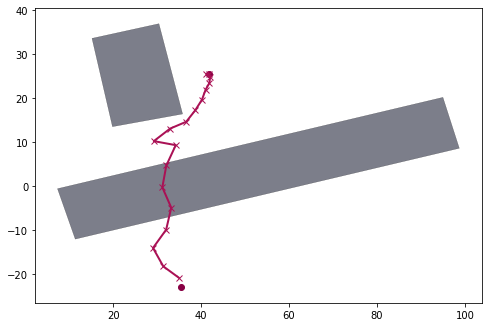

In [27]:
import argparse

from visualization import plot_map
from genetic_v2_3 import Subject, Genetic 
from data_definitions import Mapa, CartesianPoint, Conversor, GeoPoint

from file_manipulation import read_mapa, write_mavros, upload_mapa

## ENTRADA

# Parâmetros recebidos (arquivo .srv)
origin_lat       = -22.002237
origin_long      = -47.932546
origin_alt       = 13
destination_lat  = -22.002674 
destination_long = -47.932608
destination_alt  = 15

# P0
# destination_lat  = -22.002278 
# destination_long = -47.932099
# destination_alt  = 20

# P1
# destination_lat  = -22.002396 
# destination_long = -47.932063
# destination_alt  = 20


mapa_id          = 0

# Leitura do arquvio em DATA
#PATH = '/home/gustavosouza/Documents/Per/path-planning/data/mapa.json' #Ubuntu
PATH = r'../../data' #Windows
#geo_home, _, _, areas_n = read_mapa(PATH, mapa_id)
geo_home, _, _, areas_n = upload_mapa(mapa_file, mapa_id)

cart_origin      = Conversor.geo_to_cart(GeoPoint(origin_lat, origin_long, origin_alt), geo_home)
cart_destination = Conversor.geo_to_cart(GeoPoint(destination_lat, destination_long, destination_alt), geo_home)


mapa = Mapa(cart_origin, cart_destination, areas_n, inflation_rate=0.1)



## EXECUÇÃO DO AG

ag_teste = Genetic(Subject, mapa,
        # Genetic
        taxa_cross=0.5,
        population_size=100,
        C_d=1000,
        C_obs=2000,
        C_con=1000,
        C_cur=1000,
        C_t=500,
        max_exec_time=2500,
        #Subject,
        T_min=10,
        T_max=50,
        mutation_prob=0.7,
        px0=cart_origin.x,
        py0=cart_origin.y
)


best = ag_teste.run(info=True)

# Melhor rota encontrada : WPs em cartesiano
cart_points = best.get_route()

# Melhor rota encontrada : WPs em geográfico
geo_points = [ Conversor.cart_to_geo(CartesianPoint(cart_point[0], cart_point[1]), geo_home) for cart_point in cart_points ]


plot_map(
    mapa.areas_n_inf, 
    ['n' for _ in range(len(mapa.areas_n_inf))], 
    cart_origin, 
    cart_destination, 
    best.get_route(),
    None
)

## SAÍDA

#output_filename = '/mnt/c/Projetos/path-planning/algorithms/ros_genetic/path_from_ga_output.wp'
#write_mavros(output_filename, geo_points)